In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_10936\1154666483.py:9: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_10936\1154666483.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
DATA_RAW_DIR        = PROJECT_ROOT / "data_raw"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
LINEAGES_DIR        = DATA_PROCESSED_DIR / "lineages"
DATA_PROCESSED_DIR.mkdir(exist_ok=True)
LINEAGES_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)
print("Carpeta lineages:", LINEAGES_DIR)

# Leemos MANIFEST.json por coherencia (aunque aquí usamos claves locales)
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

# === SELECCIONA AQUÍ EL LINAJE A PROCESAR ===
# Tras notebook 06, las categorías finales de Level1 son:
#   "T_and_NK", "B", "Mono_and_DC", "Plasma", "pDC", "RBC", "HSCs"
#
# IMPORTANTE (tutora):
# - Sólo se van a definir subtipos Level2 para:
#       "T_and_NK", "B", "Mono_and_DC"
# - "Plasma", "pDC", "RBC" y "HSCs" se tratan como poblaciones únicas sin Level2.
#
# Por tanto, este notebook 07 SOLO debe usarse con:
#       LINEAGE in ["T_and_NK", "B", "Mono_and_DC"]

LINEAGE = "T_and_NK"   # <-- cambia aquí según el linaje que quieras procesar

print(f"\nLinaje seleccionado para este notebook: {LINEAGE}")

VALID_LINEAGES_WITH_L2    = ["T_and_NK", "B", "Mono_and_DC"]
LINEAGES_WITHOUT_LEVEL2   = ["Plasma", "pDC", "RBC", "HSCs"]

if LINEAGE in LINEAGES_WITHOUT_LEVEL2:
    raise ValueError(
        f"El linaje '{LINEAGE}' se considera población única según la tutora "
        f"(pDC / Plasma / RBC / HSCs) y no se debe procesar en notebook 07.\n"
        f"Elige uno de {VALID_LINEAGES_WITH_L2}."
    )

if LINEAGE not in VALID_LINEAGES_WITH_L2:
    raise ValueError(
        f"LINEAGE = '{LINEAGE}' no es una categoría Level1 válida para Level2.\n"
        f"Usa uno de {VALID_LINEAGES_WITH_L2}."
    )

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed
Carpeta lineages: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages

Linaje seleccionado para este notebook: T_and_NK


In [3]:
# Construimos la ruta de entrada a partir de LINEAGE
safe_l1 = LINEAGE.replace(" ", "_")
input_path = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}.h5ad"

if not input_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo por linaje para '{LINEAGE}' en:\n{input_path}\n"
        "Asegúrate de que el notebook de Level1 ha generado este archivo o ajusta la ruta."
    )

adata = sc.read_h5ad(input_path)
print(adata)

# Comprobamos que todas las células pertenecen al linaje esperado
if "Level1" not in adata.obs.columns:
    raise KeyError("No se encontró 'Level1' en adata.obs. Revisa el notebook de anotación de Level1.")

unique_level1 = adata.obs["Level1"].unique()
print("\nValores únicos de Level1 en este objeto:", unique_level1)

if len(unique_level1) != 1 or unique_level1[0] != LINEAGE:
    raise ValueError(
        f"El objeto contiene Level1 = {unique_level1}, pero esperábamos solo '{LINEAGE}'.\n"
        "Revisa qué archivo estás cargando o ajusta LINEAGE."
    )

print("\nColumnas en adata.obs:")
print(list(adata.obs.columns))

print("\nColumnas en adata.var:")
print(list(adata.var.columns))

AnnData object with n_obs × n_vars = 118426 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8', 'leiden_L1', 'Level1_auto_suggested', 'Level1'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable

In [4]:
# 4. Tipo de datos y normalización dentro del linaje

from scipy.sparse import issparse

# Decidimos qué matriz usar como base para PCA/UMAP/clustering en este linaje
BASE_LAYER = "log1p_10k"  # capa estándar creada en el notebook de normalización

if BASE_LAYER in adata.layers:
    print(f"Usando la capa '{BASE_LAYER}' como matriz base (copiada a adata.X).")
    X = adata.layers[BASE_LAYER]
    if hasattr(X, "copy"):
        adata.X = X.copy()
    else:
        adata.X = np.array(X, copy=True)
else:
    print(
        f"[AVISO] No se encontró la capa '{BASE_LAYER}'. "
        "Se usará adata.X tal y como viene del objeto de entrada."
    )

# Inspección rápida de rango numérico (conversión segura a denso en un trocito pequeño)
if issparse(adata.X):
    sample_values = adata.X[:100, :100].toarray()
else:
    sample_values = np.asarray(adata.X[:100, :100])

print("Mínimo de la matriz utilizada:", float(sample_values.min()))
print("Máximo de la matriz utilizada:", float(sample_values.max()))

Usando la capa 'log1p_10k' como matriz base (copiada a adata.X).
Mínimo de la matriz utilizada: 0.0
Máximo de la matriz utilizada: 3.019165395239876


In [5]:
ENABLE_LINEAGE_QC = False  # cambia a True si quieres aplicar QC extra dentro del linaje

# Umbrales orientativos (ajustar según las distribuciones de este linaje)
MIN_GENES_LINEAGE   = 200
MAX_GENES_LINEAGE   = None
MIN_COUNTS_LINEAGE  = 500
MAX_COUNTS_LINEAGE  = None
MAX_PCT_MT_LINEAGE  = None  # p.ej. 20.0 si quieres recortar más

if ENABLE_LINEAGE_QC:
    print("Aplicando QC adicional dentro del linaje...")
    obs = adata.obs
    mask = np.ones(adata.n_obs, dtype=bool)

    if "n_genes_by_counts" in obs.columns and MIN_GENES_LINEAGE is not None:
        mask &= obs["n_genes_by_counts"] >= MIN_GENES_LINEAGE
    if "n_genes_by_counts" in obs.columns and MAX_GENES_LINEAGE is not None:
        mask &= obs["n_genes_by_counts"] <= MAX_GENES_LINEAGE
    if "total_counts" in obs.columns and MIN_COUNTS_LINEAGE is not None:
        mask &= obs["total_counts"] >= MIN_COUNTS_LINEAGE
    if "total_counts" in obs.columns and MAX_COUNTS_LINEAGE is not None:
        mask &= obs["total_counts"] <= MAX_COUNTS_LINEAGE
    if "pct_counts_mt" in obs.columns and MAX_PCT_MT_LINEAGE is not None:
        mask &= obs["pct_counts_mt"] <= MAX_PCT_MT_LINEAGE

    n_before = adata.n_obs
    adata = adata[mask].copy()
    n_after = adata.n_obs

    print(f"Células antes del QC por linaje: {n_before}")
    print(f"Células después del QC por linaje: {n_after}")
    print(f"Células filtradas: {n_before - n_after}")
else:
    print("QC adicional desactivado (ENABLE_LINEAGE_QC = False).")

QC adicional desactivado (ENABLE_LINEAGE_QC = False).


In [6]:
# Guardamos HVG global (si existiera) antes de recalcular
if "highly_variable" in adata.var.columns:
    adata.var["highly_variable_global"] = adata.var["highly_variable"].astype(bool)
    print("Columna 'highly_variable' copiada a 'highly_variable_global' (si existía).")

# Número máximo de HVGs de linaje
N_TOP_HVGS_LINEAGE = 3000
n_genes = adata.n_vars
n_top = min(N_TOP_HVGS_LINEAGE, n_genes)

print(f"Calculando HVGs de linaje con n_top_genes = {n_top} (de {n_genes} genes disponibles)...")

# Comprobamos que existe la capa de cuentas crudas
if "counts" not in adata.layers:
    raise KeyError(
        "No se encontró la capa 'counts' en adata.layers.\n"
        "Esta capa debería haberse creado en el notebook de normalización.\n"
        "Revisa el pipeline previo antes de continuar con el análisis de Level2."
    )

sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=n_top,
    layer="counts",   # <--- usar cuentas crudas
    inplace=True,
)

print("Columnas HVG ahora presentes en adata.var:")
print([col for col in adata.var.columns if "highly_variable" in col])
print("Número de HVG de linaje:", int(adata.var["highly_variable"].sum()))

Columna 'highly_variable' copiada a 'highly_variable_global' (si existía).
Calculando HVGs de linaje con n_top_genes = 3000 (de 38606 genes disponibles)...
Columnas HVG ahora presentes en adata.var:
['highly_variable', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_global']
Número de HVG de linaje: 3000


C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Forma de adata.obsm['X_pca'] (PCA de linaje): (118426, 30)
[QA][LINEAGE] batch_key: gem_id
[QA][LINEAGE] n_batches: 8


2025-12-27 23:44:29,787 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2025-12-27 23:44:39,855 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-27 23:44:40,406 - harmonypy - INFO - Iteration 1 of 10
2025-12-27 23:45:26,842 - harmonypy - INFO - Iteration 2 of 10
2025-12-27 23:46:13,069 - harmonypy - INFO - Iteration 3 of 10
2025-12-27 23:47:00,003 - harmonypy - INFO - Converged after 3 iterations


[OK] Harmony embedding guardado en adata.obsm['X_pca_harmony_lineage']


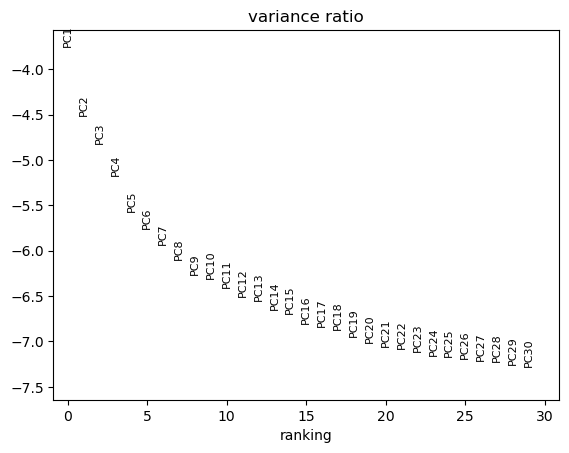

In [7]:
# PCA de linaje usando solo HVG de linaje
N_PCS_LINEAGE = 30  # PCs suficientes para un linaje; ajustable

# Trabajamos en un objeto temporal restringido a HVG para no escalar todos los genes
hvg_mask = adata.var["highly_variable"].astype(bool)
adata_hvg = adata[:, hvg_mask].copy()

# Escalado solo en HVG (sin max_value=10, siguiendo la recomendación global del proyecto)
sc.pp.scale(adata_hvg)

# PCA en HVG y copia del embedding al objeto completo
sc.tl.pca(adata_hvg, n_comps=N_PCS_LINEAGE, svd_solver="arpack")

adata.obsm["X_pca"] = adata_hvg.obsm["X_pca"].copy()

print("Forma de adata.obsm['X_pca'] (PCA de linaje):", adata.obsm["X_pca"].shape)

# ==========================
# NB07 PATCH: Harmony después de PCA (solo si hay batch>1)
# ==========================
import scanpy.external as sce

candidate_batch_keys = ["gem_id", "libraryID", "sample", "sample_id", "batch", "donor", "patientID"]
batch_key = None
for k in candidate_batch_keys:
    if k in adata.obs.columns and adata.obs[k].nunique() > 1:
        batch_key = k
        break

print("[QA][LINEAGE] batch_key:", batch_key)
if batch_key is not None:
    print("[QA][LINEAGE] n_batches:", int(adata.obs[batch_key].nunique()))

if batch_key is not None:
    # Harmony sobre la PCA cruda del linaje
    sce.pp.harmony_integrate(
        adata,
        key=batch_key,
        basis="X_pca",
        adjusted_basis="X_pca_harmony_lineage",
    )
    print("[OK] Harmony embedding guardado en adata.obsm['X_pca_harmony_lineage']")
else:
    print("[INFO] Batch=1 o sin batch_key: se mantiene X_pca sin Harmony.")

# Varianza explicada (sobre el objeto HVG)
sc.pl.pca_variance_ratio(adata_hvg, log=True)

In [8]:
LOCAL_NBR_KEY = "lineage"

N_NEIGHBORS_LINEAGE = 15  # ajustable; para linajes muy grandes se puede subir

print(
    f"Calculando grafo de vecinos local con n_neighbors = {N_NEIGHBORS_LINEAGE}, "
    f"use_rep = 'X_pca', key_added = '{LOCAL_NBR_KEY}' ..."
)

use_rep = "X_pca_harmony_lineage" if "X_pca_harmony_lineage" in adata.obsm else "X_pca"

sc.pp.neighbors(
    adata,
    n_neighbors=N_NEIGHBORS_LINEAGE,
    use_rep=use_rep,
    key_added=LOCAL_NBR_KEY,
)
print(f"[QA] neighbors.use_rep = {use_rep}")

print(f"Grafo de vecinos local almacenado en adata.uns['{LOCAL_NBR_KEY}'].")

Calculando grafo de vecinos local con n_neighbors = 15, use_rep = 'X_pca', key_added = 'lineage' ...


C:\Users\Coni\miniconda3\envs\tfm-cirrhosis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[QA] neighbors.use_rep = X_pca_harmony_lineage
Grafo de vecinos local almacenado en adata.uns['lineage'].


In [9]:
LOCAL_UMAP_KEY = "X_umap_lineage"

MIN_DIST_LINEAGE = 0.3
SPREAD_LINEAGE   = 1.0
RANDOM_STATE     = 0

print(
    f"Calculando UMAP local con neighbors_key = '{LOCAL_NBR_KEY}', "
    f"key_added = '{LOCAL_UMAP_KEY}' ..."
)

sc.tl.umap(
    adata,
    neighbors_key=LOCAL_NBR_KEY,
    min_dist=MIN_DIST_LINEAGE,
    spread=SPREAD_LINEAGE,
    random_state=RANDOM_STATE,
    key_added=LOCAL_UMAP_KEY,
)

print(f"UMAP local guardado en adata.obsm['{LOCAL_UMAP_KEY}'].")
print("Forma del embedding:", adata.obsm[LOCAL_UMAP_KEY].shape)

Calculando UMAP local con neighbors_key = 'lineage', key_added = 'X_umap_lineage' ...
UMAP local guardado en adata.obsm['X_umap_lineage'].
Forma del embedding: (118426, 2)


In [10]:
LEIDEN_L2_RESOLUTIONS = [0.3, 0.6, 1.0]

leiden_l2_keys = []

for res in LEIDEN_L2_RESOLUTIONS:
    key = f"leiden_L2_r{str(res).replace('.', '_')}"
    print(f"Calculando Leiden L2 con resolución {res} -> obs['{key}'] ...")
    sc.tl.leiden(
        adata,
        resolution=res,
        key_added=key,
        neighbors_key=LOCAL_NBR_KEY,
    )
    leiden_l2_keys.append(key)

print("\nClusterings L2 calculados:", leiden_l2_keys)

Calculando Leiden L2 con resolución 0.3 -> obs['leiden_L2_r0_3'] ...


C:\Users\Coni\AppData\Local\Temp\ipykernel_10936\3817377902.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Calculando Leiden L2 con resolución 0.6 -> obs['leiden_L2_r0_6'] ...
Calculando Leiden L2 con resolución 1.0 -> obs['leiden_L2_r1_0'] ...

Clusterings L2 calculados: ['leiden_L2_r0_3', 'leiden_L2_r0_6', 'leiden_L2_r1_0']


In [11]:
# Escogemos una resolución intermedia como base para Level2
LEIDEN_L2_MAIN_KEY = "leiden_L2_r0_6"  # ajústalo si te encaja mejor otra resolución

if LEIDEN_L2_MAIN_KEY not in adata.obs.columns:
    raise KeyError(
        f"No se encontró la columna '{LEIDEN_L2_MAIN_KEY}' en adata.obs.\n"
        f"Revisa las resoluciones calculadas: {leiden_l2_keys}"
    )

adata.obs["leiden_L2"] = adata.obs[LEIDEN_L2_MAIN_KEY].astype("category")
print(f"Columna principal de clustering de Level2 definida en obs['leiden_L2'] (basada en '{LEIDEN_L2_MAIN_KEY}').")

print("\nDistribución de 'leiden_L2':")
print(adata.obs["leiden_L2"].value_counts().sort_index())

Columna principal de clustering de Level2 definida en obs['leiden_L2'] (basada en 'leiden_L2_r0_6').

Distribución de 'leiden_L2':
leiden_L2
0     17111
1     16061
2     15473
3     13313
4     12483
5     10889
6      8606
7      8359
8      6349
9      4645
10     1576
11     1500
12      589
13      583
14      569
15      168
16      152
Name: count, dtype: int64


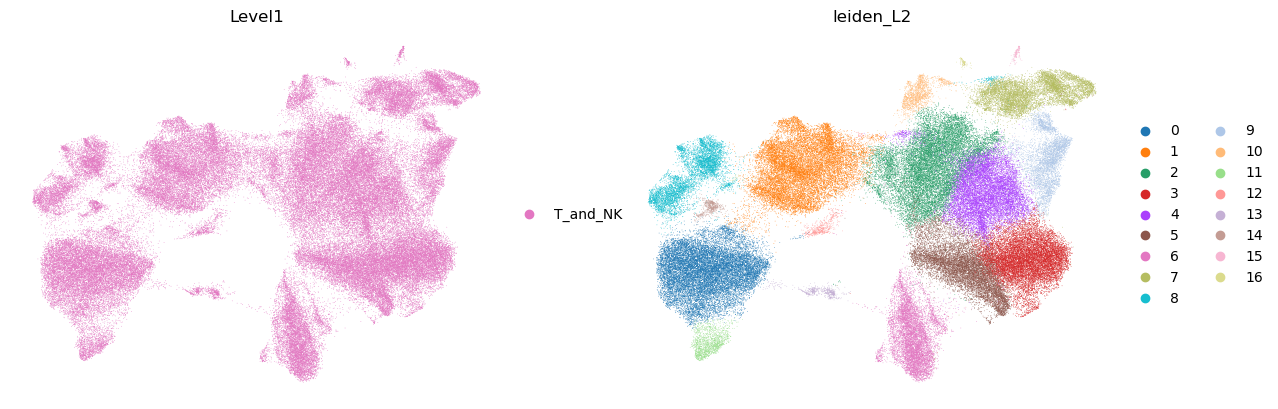

In [12]:
# Visualizamos UMAP local coloreado por Level1 y por el clustering L2
sc.pl.embedding(
    adata,
    basis=LOCAL_UMAP_KEY,
    color=["Level1", "leiden_L2"],
    ncols=2,
    frameon=False,
)

In [13]:
output_path = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}_L2embedding.h5ad"
adata.write_h5ad(output_path)

print("Objeto de linaje con embedding y clustering L2 guardado en:")
print(output_path)

Objeto de linaje con embedding y clustering L2 guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_T_and_NK_L2embedding.h5ad


## Comentario

### Análisis del Notebook 07 para el linaje B

- Para `LINEAGE = "B"`:
  - ~12k células B, con matriz base `log1p_10k` (rango ~0–2.4).
  - se seleccionan hasta 3000 HVG de linaje, manteniendo `highly_variable_global`.
  - el PCA local (30 PCs) captura bien la variabilidad interna (naive/memory, activados, ISG, etc.).
  - el UMAP local muestra varias islas bien separadas.
  - `leiden_L2_r0_6` produce ~10–11 clusters B de tamaño razonable:
    - clusters grandes para B_naive / B_memory,
    - clusters intermedios/pequeños para estados activados o ISG,
    - algún cluster muy pequeño potencialmente raro/atípico.
- Estos clusters serán mapeados en el siguiente notebook a subtipos concretos
  (B_Naive, B_Memory, B_Activated, B_ISG, etc.) usando `geneMarkers_level2["B"]`
  y análisis de expresión diferencial.